<a href="https://colab.research.google.com/github/kamkali/Malware_Discovery_ML/blob/master/DL_Malware_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Welcome to the Jupyter Notebook with Google Colab! Here we will post our research on discovering malware using machine learning.

*authors: Jakub Burghardt, Kamil Kaliś, Michał Szczepaniak-Krupowski*

In [0]:
def upload_files():
    """Function for uploading files to the project"""
    from google.colab import files
    uploaded = files.upload()
    for k, v in uploaded.items():
        open(k, 'wb').write(v)
    return list(uploaded.keys())

-----

# Part I: planning


## Main tasks:
- get acquaint with malware topic:
    - types of malware
    - frequency of appearance on different operating systems
    - detection methods: static and dynamic
    - trends
- familiarity with machine learning topic: 
    - selection of different algorithms
- most significant features pick
- dataset pick:
    - should be up to date (as current as possible)
    - should contain proper features selected earlier
- analysis of efficiency of chosen algorithms:
    - statistical comparison of accuracy, true positives/false negatives/etc.

## Assignment of the task:
### Michał Szczepaniak-Krupowski:
A deeper look at malware – types and families, comparison between static and dynamic methods.

The popularity of malware on different OS – why Windows users are the most threatened on the malicious software attack?

### Kamil Kaliś:
What is Machine Learning and why is it crucial in Cybersecurity – the need for accelerating the usage of ML in modern detecting malware.

Comparison of different supervised learning algorithms – pros and cons in malware detection.

### Jakub Burghardt:
Malware detection methods – more detailed reasoning about static detection methods.

A brief look at PE format (Portable Executable) – how can they be helpful in detecting malware with static methods?

-----

# Mid-term presentation
### link to presentation:
https://drive.google.com/open?id=1x1DcDueWrDM8XHEd-sKMWykt5G3wMW9X-8NbKFgRhmk

# Project implementation:

># *'Before'* section:

Code snippet to upload MalwareData.csv if not already in colab directory:

In [0]:
import os
if not os.path.exists('Malware_Discovery_ML'):
    !git clone https://github.com/kamkali/Malware_Discovery_ML
    !unzip Malware_Discovery_ML/MalwareData.csv.zip
    # !unzip Malware_Discovery_ML/KNN_logs.zip

Logger module to save outputs from functions:

In [0]:
import logging
import functools
import time

"""Logger module created by Kamil Kaliś"""


def logger_setup(logger_file="results.log"):
    """Sets up the logger.
    Usage:
        1. With wrapper @log_to_file(logger_file=<loggername.log>)
        2. Set logger within module as:
            2.1 log = get_logger(logger_file-<loggername.log>)
            2.2 use 'log' variable to use logger and write them to file"""

    logformat = "[%(asctime)s %(levelname)s] %(message)s"
    dateformat = "%d-%m-%y %H:%M:%S"
    logger = logging.getLogger(logger_file)
    formatter = logging.Formatter(logformat)
    formatter.datefmt = dateformat
    fh = logging.FileHandler(logger_file, mode="a")
    fh.setFormatter(formatter)
    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.setLevel(logging.INFO)
    logger.addHandler(fh)
    logger.addHandler(sh)
    logger.propagate = False


def log_to_file(func=None, logger_file='results.log'):
    def log_exec_time(original_func):
        """Wrapper for logging execution time of marked function.
        Usage:
        Add adnotation above function: '@log_to_file(<logger_file.log>)'"""

        @functools.wraps(original_func)
        def wrapper(*args, **kwargs):
            log = logging.getLogger(logger_file)
            log.info(f"Running {original_func.__name__}...")
            start_time = time.time()
            result = original_func(*args, **kwargs)
            exec_time = time.time() - start_time
            log.info(f"Function {original_func.__name__} finished in {exec_time}s")
            return result

        return wrapper

    return log_exec_time if func is None else log_exec_time(func)


def get_logger(logger_file='results.log'):
    return logging.getLogger(logger_file)


--------

> # K-Nearest Neighbors:
*author: Kamil Kaliś*

One simple way to solve malware detection problems is to use the K-Nearest Neighbors algorithm. KNN model from the third-party library (*sklearn*) will be used.
We also need data to work on and in this case, it is collected in *MalwareData.csv* file. To process data, *pandas* library and sklearn modules are used. To visualize data and charts *plotly* library will be used.

As mentioned above, let's start with importing adequate libraries and modules:

In [0]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

In [0]:
LOGGER_FILE = 'KNN_results_runtime.log'

Then, read data to work on:

In [6]:
data = pd.read_csv('MalwareData.csv', sep='|')
print(data.shape[0], data.shape[1])
benign_files = data[data['legitimate'] == 1].count()
malware_files = data[data['legitimate'] == 0].count()
print(f"Clean files count is {benign_files[1]} and malware files count is {malware_files[1]}")

138047 57
Clean files count is 41323 and malware files count is 96724


MalwareData.csv contains 138 047 records as a whole, where 41 323 files are benign, clean files, and 96 724 files which are malicious. 
Data is reprezented with 56 features. Last 57'th feature represents a label *legitimate* classifies given sample:

'1' – for clean file, '0' – for malware file.

Knowing all this, we can start to process the data to more algorithm friendly form.

## Function: malware_data_transform

### **@description:** 
> Performs data transform as dropping insignificant columns and 'legitimate' column, which contains labels. It can normalize or standardize data.

### **@params:**

>*   optimize_data – enables data normalization or standardization: 
default is None
>*   csv_data – cvs file to read and transform:
default is MalwareData.csv
>*   csv_sep – separator used in csv file:
default is '|'
>*   enable figures – enables plotly charts to show:
default is False

### **@returns:**


> full_data.values, labels – tuple with values of features and labels for malicious and clean files








In [0]:
@log_to_file(logger_file=LOGGER_FILE)
def malware_data_transform(optimize_data=None, csv_data='MalwareData.csv', csv_sep='|', enable_figures=False):
    log = get_logger(logger_file=LOGGER_FILE)
    log.info("-Reading csv file")
    full_data = pd.read_csv(csv_data, sep=csv_sep)

    pd.set_option("display.max_columns", None)

    labels = full_data['legitimate'].values
    full_data: pd.DataFrame = full_data.drop(['Name', 'md5', 'legitimate'], axis=1)

    if optimize_data == 'normalize':
        log.info("--Data normalization processing...")
        full_data = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(full_data))
    elif optimize_data == 'standardize':
        log.info("--Data standardization processing...")
        full_data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(full_data))

    if enable_figures:
        log.info("--Figures enabled")
        plot_bar_figures(full_data, optimize_data)

    return full_data.values, labels


When transforming data, it is good to see how it looks like. The next function provides a utility to show non-optimized data, normalized or standardized forms of data.

## Function: plot_bar_figures

### **@description:** 
> Function to plot bar charts with features values
### **@params:**


>*   optimize_data – enables data normalization or standardization: 
default is None
>*   full_data – transformed data

### **@returns:**
> Nothing








In [0]:
def plot_bar_figures(full_data, optimize_data):
    cols = full_data.keys()
    if optimize_data == 'normalize':
        cols = full_data.keys()
        full_data_normalized = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(full_data))
        trace_norm_mean: pd.DataFrame = full_data_normalized.mean()
        trace_norm_std: pd.DataFrame = full_data_normalized.std()

        # -------------------------------------------------
        layout = go.Layout(title='Normalized data mean')
        figure = go.Figure(go.Bar(y=trace_norm_mean,
                                  x=cols
                                  ), layout=layout)
        figure.show()
        # -------------------------------------------------
        layout = go.Layout(title='Normalized data standard deviation')
        figure = go.Figure(go.Bar(y=trace_norm_std,
                                  x=cols
                                  ), layout=layout)
        figure.show()

    elif optimize_data == 'standardize':
        cols = full_data.keys()

        full_data_standardized = pd.DataFrame(preprocessing.StandardScaler().fit_transform(full_data))
        trace_stand_mean = full_data_standardized.mean()
        trace_stand_std = full_data_standardized.std()

        # -------------------------------------------------
        layout = go.Layout(title='Standardized data mean')
        figure = go.Figure(go.Bar(y=trace_stand_mean,
                                  x=cols
                                  ), layout=layout)
        
        figure.show()
        # -------------------------------------------------
        layout = go.Layout(title='Standardized data standard deviation')
        figure = go.Figure(go.Bar(y=trace_stand_std,
                                  x=cols
                                  ), layout=layout)
        figure.show()
    else:
        trace_mean = full_data.mean()
        trace_std = full_data.std()

        # -------------------------------------------------
        layout = go.Layout(title='Data mean')
        figure = go.Figure(go.Bar(y=trace_mean,
                                  x=cols
                                  ), layout=layout)
        figure.show()
        # -------------------------------------------------
        layout = go.Layout(title='Data standard deviation')
        figure = go.Figure(go.Bar(y=trace_std,
                                  x=cols
                                  ), layout=layout)
        figure.show()

The classifier is built using *sklearn* library. To get the best results, it needs to be parameterized and analyzed with different combinations of parameters, like:
* Numbers of neighbors
* Number of features and proper algorithm to choose them
* Different metrics and weights in KNN algorithm
* Non-optimized or normalized / standardized data

## Function: knn_classifier

### **@description:** 
> Function to fit KNN classifier for different params and receive metrics, like accuracy, precision, recall percentage, false positives  and false negatives percentage.
### **@params:**


>*   input data – data applied to teach algorithm
>*   labels – 0/1 label for each sample in input data
>*   n_neighbors - upper limit of neighbors to classify with (descending order):
default is 1
>*   run_for_features – tuple of starting number of features to select, step, upper limit: default is (3, 30, 20)

### **@returns:**
> Nothing








In [0]:
@log_to_file(logger_file=LOGGER_FILE)
def knn_classifier(input_data, labels, n_neighbors=1, run_for_features=(3, 30, 20)):
    log = get_logger(logger_file=LOGGER_FILE)
    for n in range(1, n_neighbors + 1):
        log.info(f"-Running KNN algorithm with n_neighbors={n_neighbors}")
        weights = ['distance', 'uniform']
        metrics = ['chebyshev', 'euclidean', 'manhattan']
        for metric in metrics:
            for weight in weights:
                classifier = neighbors.KNeighborsClassifier(n_neighbors, weights=weight, metric=metric)
                for k in range(*run_for_features):
                    start_time = time.time()
                    log.info(f"--Finding best {k} features")
                    best_features_data = SelectKBest(f_classif, k=k).fit_transform(input_data, labels)
                    X_train, X_test, Y_train, Y_test = train_test_split(best_features_data, labels, test_size=0.3)

                    log.info(f"---Starting fitting for weight={weight} and metric={metric}")
                    classifier.fit(X_train, Y_train)

                    score = classifier.score(X_test, Y_test)

                    """ Confusion matrix """
                    log.info("----Measuring confusion matrix...")
                    result = classifier.predict(X_test)
                    conf_matrix = confusion_matrix(Y_test, result)

                    log.info(f"-----KNN accuracy is: {score * 100}%")

                    precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1]) * 100
                    log.info(f"-----Precision in percent: {precision}%")

                    recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0]) * 100
                    log.info(f"-----Recall in percent: {recall}%")

                    false_positives = conf_matrix[0][1] / sum(conf_matrix[0]) * 100
                    log.info(f"-----False positives in percent: {false_positives}%")

                    false_negatives = conf_matrix[1][0] / sum(conf_matrix[1]) * 100
                    log.info(f"-----False negatives in percent: {false_negatives}%")
                    log.info(f"Exec time for {k} features: {time.time() - start_time}s")


The output of functions is collected by the logger module. Output file with results is named *KNN_results_runtime.log*.

Below is the section, which evokes the above functions. It is *main* part of the program.

In [10]:
logger_setup(logger_file=LOGGER_FILE)
get_logger(logger_file=LOGGER_FILE).info("---------------Starting---------------")
get_logger(logger_file=LOGGER_FILE).info("--------------------------------------")

[20-01-20 19:07:31 INFO] ---------------Starting---------------
[20-01-20 19:07:31 INFO] --------------------------------------


In [11]:
input_data, labels = malware_data_transform(enable_figures=True)
knn_classifier(input_data, labels, 1, (3, 24, 20))

[20-01-20 19:07:31 INFO] Running malware_data_transform...
[20-01-20 19:07:31 INFO] -Reading csv file
[20-01-20 19:07:32 INFO] --Figures enabled


[20-01-20 19:07:33 INFO] Function malware_data_transform finished in 1.7889420986175537s
[20-01-20 19:07:33 INFO] Running knn_classifier...
[20-01-20 19:07:33 INFO] -Running KNN algorithm with n_neighbors=1
[20-01-20 19:07:33 INFO] --Finding best 3 features
[20-01-20 19:07:33 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:07:39 INFO] ----Measuring confusion matrix...
[20-01-20 19:07:41 INFO] -----KNN accuracy is: 96.4336593021852%
[20-01-20 19:07:41 INFO] -----Precision in percent: 97.39534883720931%
[20-01-20 19:07:41 INFO] -----Recall in percent: 97.51293549499827%
[20-01-20 19:07:41 INFO] -----False positives in percent: 2.604651162790698%
[20-01-20 19:07:41 INFO] -----False negatives in percent: 5.8192090395480225%
[20-01-20 19:07:41 INFO] Exec time for 3 features: 7.847141981124878s
[20-01-20 19:07:41 INFO] --Finding best 23 features
[20-01-20 19:07:41 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:07:55 INFO] ----M

When data is a raw input without optimization, charts show that the value of one feature dominates another one. The function executes quickly, because it may enter this dominant value and pretend based on its value. However, results, in this case, may not be the most accurate.

In [12]:
get_logger(logger_file=LOGGER_FILE).info("--------------------------------------")
input_data, labels = malware_data_transform(optimize_data='normalize', enable_figures=True)
knn_classifier(input_data, labels, 1, (3, 24, 20))

[20-01-20 19:10:45 INFO] --------------------------------------
[20-01-20 19:10:45 INFO] Running malware_data_transform...
[20-01-20 19:10:45 INFO] -Reading csv file
[20-01-20 19:10:46 INFO] --Data normalization processing...
[20-01-20 19:10:46 INFO] --Figures enabled


[20-01-20 19:10:46 INFO] Function malware_data_transform finished in 1.5447800159454346s
[20-01-20 19:10:46 INFO] Running knn_classifier...
[20-01-20 19:10:46 INFO] -Running KNN algorithm with n_neighbors=1
[20-01-20 19:10:46 INFO] --Finding best 3 features
[20-01-20 19:10:47 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:10:51 INFO] ----Measuring confusion matrix...
[20-01-20 19:10:53 INFO] -----KNN accuracy is: 96.50368224073404%
[20-01-20 19:10:53 INFO] -----Precision in percent: 97.46206896551725%
[20-01-20 19:10:53 INFO] -----Recall in percent: 97.54279403644396%
[20-01-20 19:10:53 INFO] -----False positives in percent: 2.5379310344827584%
[20-01-20 19:10:53 INFO] -----False negatives in percent: 5.734997986306887%
[20-01-20 19:10:53 INFO] Exec time for 3 features: 6.6847357749938965s
[20-01-20 19:10:53 INFO] --Finding best 23 features
[20-01-20 19:10:53 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:11:20 INFO] ---

After performing data normalization - a process of eliminating units of data, enabling to compare data more easily - mean value and std are looking better. It affects algorithm execution time, which doubles, but it performs better on data rescaled to values ​​between 0 and 1. The algorithm predicts classes more accurate and False positives/negatives results lower.
Precision and recall measurements for normalized data is above 99%, which is a satisfying result.

In [13]:
get_logger(logger_file=LOGGER_FILE).info("--------------------------------------")
input_data, labels = malware_data_transform(optimize_data='standardize', enable_figures=True)
knn_classifier(input_data, labels, 1, (3, 24, 20))

[20-01-20 19:17:48 INFO] --------------------------------------
[20-01-20 19:17:48 INFO] Running malware_data_transform...
[20-01-20 19:17:48 INFO] -Reading csv file
[20-01-20 19:17:49 INFO] --Data standardization processing...
[20-01-20 19:17:49 INFO] --Figures enabled


[20-01-20 19:17:50 INFO] Function malware_data_transform finished in 1.5547454357147217s
[20-01-20 19:17:50 INFO] Running knn_classifier...
[20-01-20 19:17:50 INFO] -Running KNN algorithm with n_neighbors=1
[20-01-20 19:17:50 INFO] --Finding best 3 features
[20-01-20 19:17:50 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:17:53 INFO] ----Measuring confusion matrix...
[20-01-20 19:17:54 INFO] -----KNN accuracy is: 96.37812386816371%
[20-01-20 19:17:54 INFO] -----Precision in percent: 97.51242064587359%
[20-01-20 19:17:54 INFO] -----Recall in percent: 97.31767784587838%
[20-01-20 19:17:54 INFO] -----False positives in percent: 2.4875793541264146%
[20-01-20 19:17:54 INFO] -----False negatives in percent: 6.2665915855522485%
[20-01-20 19:17:54 INFO] Exec time for 3 features: 4.4405481815338135s
[20-01-20 19:17:54 INFO] --Finding best 23 features
[20-01-20 19:17:54 INFO] ---Starting fitting for weight=distance and metric=chebyshev
[20-01-20 19:18:22 INFO] --

After data standardization – a process of transforming data to have a mean of zero and a standard deviation of 1 – there are similar results and conclusions as with data normalization. Both are giving promising results of accuracy and precision above 99%.

In [14]:
get_logger(logger_file=LOGGER_FILE).info("--------------------------------------")
get_logger(logger_file=LOGGER_FILE).info("---------------Stopping---------------")

[20-01-20 19:25:16 INFO] --------------------------------------
[20-01-20 19:25:16 INFO] ---------------Stopping---------------


Below is an output from functions run above.

In [0]:
ENABLE_LONG_LOGS = False    # change to True to enable long logger outputs

In [0]:
if ENABLE_LONG_LOGS:
    import os
    if os.path.exists('KNN_results_runtime.log'):
        !cat KNN_results.log

## Algorithm parameters selection
Because running whole script can last a long time, measurements have been carried out earlier and analyzed for best parameter selection.

In [28]:
import os
if os.path.exists('Malware_Discovery_ML/KNN/results_analyze.txt'):
    !cat Malware_Discovery_ML/KNN/results_analyze.txt

For not optimized data --> k=1 – best result for weight=uniform and metric=manhattan and 23 features
[28-12-19 14:07:31 INFO] ---Starting fitting for weight=uniform and metric=manhattan
[28-12-19 14:07:46 INFO] ----Measuring confusion matrix...
[28-12-19 14:07:57 INFO] -----KNN accuracy is: 97.98140770252324%
[28-12-19 14:07:57 INFO] -----Precision in percent: 98.56965602812436%
[28-12-19 14:07:57 INFO] -----Recall in percent: 98.54927636113025%
[28-12-19 14:07:57 INFO] -----False positives in percent: 1.430343971875646%
[28-12-19 14:07:57 INFO] -----False negatives in percent: 3.3948875090718493%


For normalized data --> k=1 – best result for weight=distance and metric=manhattan and 23 features
[28-12-19 14:15:17 INFO] --Finding best 23 features
[28-12-19 14:15:18 INFO] ---Starting fitting for weight=distance and metric=manhattan
[28-12-19 14:15:50 INFO] ----Measuring confusion matrix...
[28-12-19 14:16:06 INFO] -----KNN accuracy is: 99.19594349873235%
[28-12-19 14:16:06 INFO] -----P

In [0]:
@log_to_file(logger_file='KNN_final.log')
def knn_classifier_final_model(input_data, labels):
    log = get_logger(logger_file=LOGGER_FILE)
    log.info(f"-Running final KNN algorithm model with n_neighbors=8")
    weight = 'distance'
    metric = 'manhattan'

    classifier = neighbors.KNeighborsClassifier(8, weights=weight, metric=metric)
    start_time = time.time()
    log.info(f"--Finding best 30 features")
    best_features_data = SelectKBest(f_classif, k=30).fit_transform(input_data, labels)
    X_train, X_test, Y_train, Y_test = train_test_split(best_features_data, labels, test_size=0.3)

    log.info(f"---Starting fitting for weight={weight} and metric={metric}")
    classifier.fit(X_train, Y_train)

    score = classifier.score(X_test, Y_test)

    """ Confusion matrix """
    log.info("----Measuring confusion matrix...")
    result = classifier.predict(X_test)
    conf_matrix = confusion_matrix(Y_test, result)

    log.info(f"-----KNN accuracy is: {score * 100}%")

    precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1]) * 100
    log.info(f"-----Precision in percent: {precision}%")

    recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0]) * 100
    log.info(f"-----Recall in percent: {recall}%")

    false_positives = conf_matrix[0][1] / sum(conf_matrix[0]) * 100
    log.info(f"-----False positives in percent: {false_positives}%")

    false_negatives = conf_matrix[1][0] / sum(conf_matrix[1]) * 100
    log.info(f"-----False negatives in percent: {false_negatives}%")
    log.info(f"Exec time for 30 features: {time.time() - start_time}s")

Model is performing best with 8 neighbors, 30 features selected by function *SelectKBest* (thus it can vary, but not much) and fed with standardized data. The algorithm is running for about 60 seconds.

In [19]:
    get_logger(logger_file=LOGGER_FILE).info("--------------------------------------")
    input_data, labels = malware_data_transform(optimize_data='standardize', enable_figures=False)
    knn_classifier_final_model(input_data, labels)

[20-01-20 19:25:18 INFO] --------------------------------------
[20-01-20 19:25:18 INFO] Running malware_data_transform...
[20-01-20 19:25:18 INFO] -Reading csv file
[20-01-20 19:25:19 INFO] --Data standardization processing...
[20-01-20 19:25:19 INFO] Function malware_data_transform finished in 1.136582612991333s
[20-01-20 19:25:19 INFO] -Running final KNN algorithm model with n_neighbors=8
[20-01-20 19:25:19 INFO] --Finding best 30 features
[20-01-20 19:25:19 INFO] ---Starting fitting for weight=distance and metric=manhattan
[20-01-20 19:26:19 INFO] ----Measuring confusion matrix...
[20-01-20 19:27:09 INFO] -----KNN accuracy is: 99.29735603042376%
[20-01-20 19:27:09 INFO] -----Precision in percent: 99.31488078925733%
[20-01-20 19:27:09 INFO] -----Recall in percent: 99.68710243097341%
[20-01-20 19:27:09 INFO] -----False positives in percent: 0.6851192107426692%
[20-01-20 19:27:09 INFO] -----False negatives in percent: 0.7444980773950749%
[20-01-20 19:27:09 INFO] Exec time for 30 featu

In [0]:
import os
if ENABLE_LONG_LOGS:
    if os.path.exists('Malware_Discovery_ML/KNN/loggerOutputs/KNN_results.log'):
        !cat Malware_Discovery_ML/KNN/loggerOutputs/KNN_results.log
    if os.path.exists('Malware_Discovery_ML/KNN/loggerOutputs/KNN_standardized_data.log'):
        !cat Malware_Discovery_ML/KNN/loggerOutputs/KNN_standardized_data.log
    if os.path.exists('Malware_Discovery_ML/KNN/loggerOutputs/KNN_k8_features.log'):
        !cat Malware_Discovery_ML/KNN/loggerOutputs/KNN_k8_features.log
    if os.path.exists('Malware_Discovery_ML/KNN/loggerOutputs/KNN_final.log'):
        !cat Malware_Discovery_ML/KNN/loggerOutputs/KNN_final.log

# Decision Tree


In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz
import numpy as np
import time
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
import warnings

warnings.filterwarnings("ignore")

In [0]:
svc_list = []
svc_features = []

tree_selection_list = []
tree_selection_features = []

none_feature_list = []

In [0]:
def get_average_confusion_matrix(list, name):
    a = list[0][0]
    b = list[0][1]

    for single_matrix in list:
        a = np.vstack((a, single_matrix[0]))
        b = np.vstack((b, single_matrix[1]))

    a = np.delete(a, (0), axis=0)
    b = np.delete(b, (0), axis=0)

    a_average = np.mean(a, axis=0)
    b_average = np.mean(b, axis=0)

    average_matrix = list[0][0]
    average_matrix = np.vstack((average_matrix, a_average))
    average_matrix = np.vstack((average_matrix, b_average))
    average_matrix = np.delete(average_matrix, 0, axis=0)

    df_cm = pd.DataFrame(average_matrix, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')  # font size
    plt.title(str(name) + " feature selection")
    plt.show()


def get_confusion_matrix(Y, predictions, name):
    matrix = confusion_matrix(Y, predictions)
    if name == "LinearSVC":
        svc_list.append(matrix)
    if name == "Tree selection":
        tree_selection_list.append(matrix)
    if name == "None":
        none_feature_list.append(matrix)



def show_graph(my_classifier, feautures_names, name):
    dot_data = tree.export_graphviz(my_classifier, out_file=None,
                                    feature_names=feautures_names,
                                    class_names=[str(0), str(1)],
                                    filled=True, rounded=True,
                                    special_characters=False)
    graph = graphviz.Source(dot_data)
    graph.render("decision_graph_" + str(name) + ".dot")


def train_decision_tree(X, Y, name):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    my_classifier = tree.DecisionTreeClassifier()
    my_classifier.fit(X_train, Y_train)
    score = my_classifier.score(X_test, Y_test)
    predictions = my_classifier.predict(X_test)
    if name == "LinearSVC":
        svc_features.append(X.shape[1])
    if name == "Tree selection":
        tree_selection_features.append(X.shape[1])
    get_confusion_matrix(Y_test, predictions, name)

def test_SVC_loop(X, Y, loop_range):
    for i in range(loop_range):
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
        model = SelectFromModel(lsvc, prefit=True)
        X_new_L1 = model.transform(X)
        train_decision_tree(X_new_L1, Y, "LinearSVC")


def test_extra_tree_loop(X, Y, loop_range):
    for i in range(loop_range):
        clf = ExtraTreesClassifier().fit(X, Y)
        feature_selection = SelectFromModel(clf, prefit=True)
        X_new_tree_based = feature_selection.transform(X)
        train_decision_tree(X_new_tree_based, Y, "Tree selection")


def test_no_features_selection_loop(X, Y, loop_range):
    for i in range(loop_range):
        train_decision_tree(X, Y, "None")


In [24]:
print("--- main starts ---")
data = pd.read_csv("MalwareData.csv", sep='|')
feautures_names = data.drop(['Name', 'md5', 'legitimate'], axis=1).columns
X = data.drop(['Name', 'md5', 'legitimate'], axis=1).values

Y = data['legitimate'].values

--- main starts ---


--- LinearSVC Starts! ---
SVC average confusion matrix : 


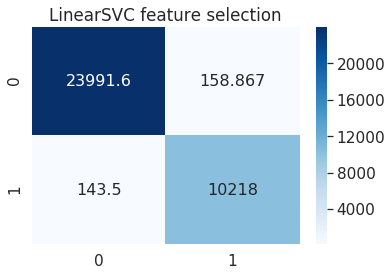

Average amount of features in SVC feature selection: 27.3
Average training time : 12.128770128885906
--- 363.86310386657715 seconds ---


In [25]:
print("--- LinearSVC Starts! ---")
start_time = time.time()
test_SVC_loop(X, Y, 30)

print("SVC average confusion matrix : ")
get_average_confusion_matrix(svc_list, "LinearSVC")

svc_average_features_amount = sum(svc_features) / len(svc_features)
print("Average amount of features in SVC feature selection: " + str(svc_average_features_amount))

training_time = time.time() - start_time
average_training_time = training_time/30
print("Average training time : " + str(average_training_time))
print("--- %s seconds ---" % (training_time))

--- ExtraTree Starts! ---
Tree Selection average matrix : 


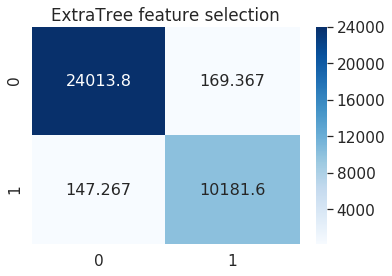

Average amount of features in Tree Selection:  13.3
Average training time : 14.590334876378376
--- 437.7100462913513 seconds ---


In [26]:
print("--- ExtraTree Starts! ---")
start_time = time.time()
test_extra_tree_loop(X, Y, 30)

print("Tree Selection average matrix : " )
get_average_confusion_matrix(tree_selection_list, "ExtraTree")

tree_features_average_amount = sum(tree_selection_features) / len(tree_selection_features)
print("Average amount of features in Tree Selection:  " + str(tree_features_average_amount))

training_time = time.time() - start_time
average_training_time = training_time/30
print("Average training time : " + str(average_training_time))
print("--- %s seconds ---" % (training_time))

--- No Features Starts! ---
No feature selection average confusion matrix : 


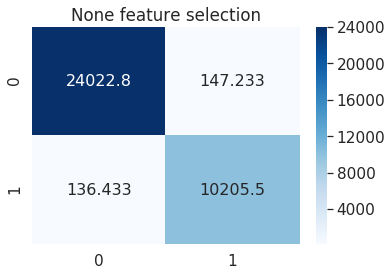

Amount of features : 54
Average training time : 4.8840210199356076
--- 146.52063059806824 seconds ---


In [27]:
print("--- No Features Starts! ---")
start_time = time.time()
test_no_features_selection_loop(X, Y, 30)

print("No feature selection average confusion matrix : ")
get_average_confusion_matrix(none_feature_list, "None")

training_time = time.time() - start_time
average_training_time = training_time/30
print("Amount of features : " + str(X.shape[1]))
print("Average training time : " + str(average_training_time))
print("--- %s seconds ---" % (training_time))